In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import special as sp

In [2]:
# beta=2.0
Nc=3

In [3]:
class Jackknife:
    def __init__( self, len_data, binsize ):
        self.binsize = binsize
        self.nbins = int(np.floor( len_data/self.binsize ))
        self.N = self.binsize * self.nbins
        self.jack_avg = []
        self.est = 0
        self.var_est = 0

    def set( self, func, list_of_data ):
        for i in range( self.nbins ):
            self.jack_avg.append( func( i, self.binsize, list_of_data ) )

    def do_it( self ):
        for i in range( 0, self.nbins ):
            self.est += self.jack_avg[i]
        self.est /= self.nbins

        for i in range( 0, self.nbins ):
            self.var_est += ( self.jack_avg[i] - self.est )**2
        self.var_est /= self.nbins
        self.var_est *= self.nbins -1

    def mean( self ):
        return self.est

    def var( self ):
        return self.var_est

    def err( self ):
        return np.sqrt(self.var_est)

def simple_mean(i, binsize, np_data):
    resmpld = np.delete(np_data, np.s_[i*binsize:(i+1)*binsize])
    return np.mean(resmpld)

def format_print(cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'

def format_print_w_exact(exact, cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'+': '+'{num:.{width}f}'.format(num=(exact-cen)/err, width=i+1)+' sigma'

In [53]:
def get_matrix( Q, lam, beta ):
    mat = np.matrix( [[sp.ive(k-ell+Q+lam[ell], beta/Nc) for ell in range(Nc)] for k in range(Nc)] )
    return mat

def cF( lam, beta ):
    res = np.linalg.det( get_matrix(0, lam, beta) )
    tmp = res
    for Q in range(1,1000):
        res += np.linalg.det( get_matrix(Q, lam, beta) )
        res += np.linalg.det( get_matrix(-Q, lam, beta) )
        
        if abs(res-tmp)<1.0e-15:
            break        
        tmp = res
    return res

In [54]:
lam00 = np.zeros(Nc)
#
lam10 = np.zeros(Nc)
lam10[0] = 1
lam10[1] = 0
#
lam11 = np.zeros(Nc)
lam11[0] = 1
lam11[1] = 1
#
lam20 = np.zeros(Nc)
lam20[0] = 2
lam20[1] = 0
#
lam21 = np.zeros(Nc)
lam21[0] = 2
lam21[1] = 1
#
lam22 = np.zeros(Nc)
lam22[0] = 2
lam22[1] = 2
#
lam30 = np.zeros(Nc)
lam30[0] = 3
lam30[1] = 0
#
lam31 = np.zeros(Nc)
lam31[0] = 3
lam31[1] = 1
#
lam32 = np.zeros(Nc)
lam32[0] = 3
lam32[1] = 2
#
lam33 = np.zeros(Nc)
lam33[0] = 3
lam33[1] = 3

In [55]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size'  : 22
})
plt.rc('font',family='Times New Roman')

In [56]:
binsize=5
N=1000

In [57]:
res_=[]
for beta in np.arange(1.0, 3.05, 0.05):
    betastr='{:.6f}'.format(beta)
    retrU = np.loadtxt( "obs"+betastr+"_5.000000_1.000000_/retrU"+betastr+"_.dat" )

    jk1 = Jackknife( N, binsize )
    jk1.set( simple_mean, retrU.T[1] )
    jk1.do_it()

    exact = cF( lam10, beta )/cF( lam00, beta )
    res_.append([beta, exact, jk1.mean(), jk1.err()])
    # print("ReTrU", format_print_w_exact( exact, jk1.mean(), jk1.err() ))

In [148]:
binsize=200

In [149]:
beta=3.05
betastr='{:.6f}'.format(beta)
retrU = np.loadtxt( "run3/obs"+betastr+"_5.000000_1.000000_/retrU"+betastr+"_.dat" )
jk1 = Jackknife( N, binsize )
jk1.set( simple_mean, retrU.T[1] )
jk1.do_it()
exact = cF( lam10, beta )/cF( lam00, beta )

print("ReTrU", format_print_w_exact( exact, jk1.mean(), jk1.err() ))

ReTrU 0.62084(35): -0.50676 sigma


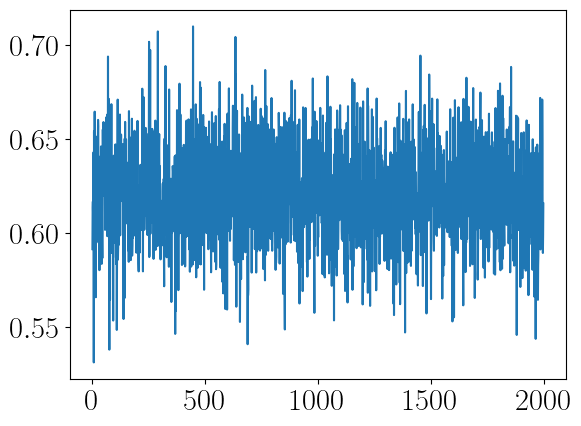

In [150]:
plt.plot( retrU.T[1] )

In [47]:
exact

0.6206654386814253

In [121]:
for beta in np.arange(3.05, 4.0, 0.05):
    betastr='{:.6f}'.format(beta)
    retrU = np.loadtxt( "run2/obs"+betastr+"_5.000000_1.000000_/retrU"+betastr+"_.dat" )

    jk1 = Jackknife( N, binsize )
    jk1.set( simple_mean, retrU.T[1] )
    jk1.do_it()

    exact = cF( lam10, beta )/cF( lam00, beta )
    res_.append([beta, exact, jk1.mean(), jk1.err()])
    # print("ReTrU", format_print_w_exact( exact, jk1.mean(), jk1.err() ))

In [122]:
res = np.array(res_)

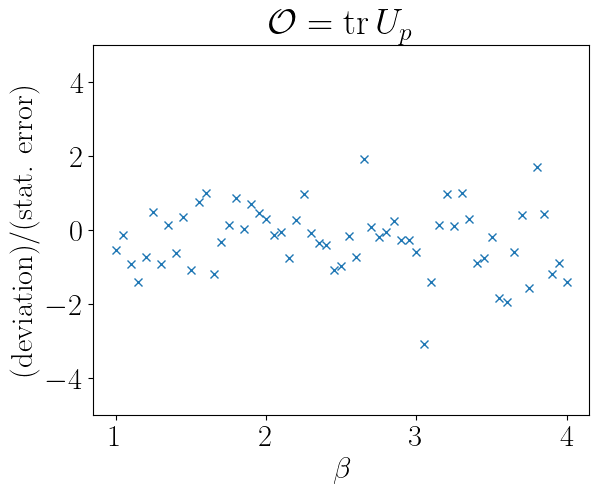

In [123]:
diff = res.T[2]-res.T[1]

plt.plot( res.T[0], diff / res.T[3], ls="none", marker="x")

plt.ylim(-5, 5)

plt.xlabel("$\\beta$")
plt.ylabel("(deviation)/(stat. error)")
plt.title("${\\cal O} = {\\rm tr} \,U_p $")

plt.savefig("trUerr.pdf", bbox_inches="tight")

In [124]:
xx = np.arange( 1.0, 4.0, 0.01 )
yy = np.array( [cF( lam10, beta )/cF( lam00, beta ) for beta in xx ] )

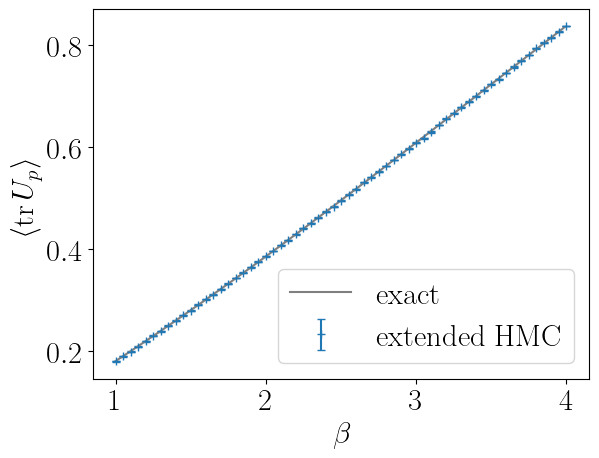

In [125]:
plt.errorbar( res.T[0], res.T[2], res.T[3], 
             ls='none', marker="+",
             capsize=3.0, label="extended HMC")

plt.plot( xx, yy, label="exact", c='gray' )

plt.xlabel("$\\beta$")
plt.ylabel("$\\langle {\\rm tr} \,U_p \\rangle$")
plt.legend(loc="lower right")
# plt.title("$SU(3)$, single plaquette, trivial $G$")

plt.savefig("trU.pdf", bbox_inches="tight")

In [151]:
binsize=10
N=1000

In [152]:
res_=[]
for beta in np.arange(1.0, 3.05, 0.05):
    betastr='{:.6f}'.format(beta)
    retrU = np.loadtxt( "obs"+betastr+"_5.000000_1.000000_/retrUsq"+betastr+"_.dat" )

    jk1 = Jackknife( N, binsize )
    jk1.set( simple_mean, retrU.T[1] )
    jk1.do_it()

    exact = (cF(lam20,beta)+cF(lam11,beta))/cF( lam00, beta )
    res_.append([beta, exact, jk1.mean(), jk1.err()])
    print("ReTrU", format_print_w_exact( exact, jk1.mean(), jk1.err() ))

ReTrU 0.1965(12): 0.1345 sigma
ReTrU 0.2074(13): 0.5385 sigma
ReTrU 0.2186(12): 1.0130 sigma
ReTrU 0.2293(12): 2.0230 sigma
ReTrU 0.2425(11): 1.0824 sigma
ReTrU 0.2569(14): -0.7104 sigma
ReTrU 0.2673(13): 0.7304 sigma
ReTrU 0.2818(12): -0.8058 sigma
ReTrU 0.2920(13): 1.1650 sigma
ReTrU 0.3067(13): -0.2359 sigma
ReTrU 0.3177(13): 1.3357 sigma
ReTrU 0.3344(14): -1.1749 sigma
ReTrU 0.3477(13): -1.2503 sigma
ReTrU 0.3581(14): 1.1716 sigma
ReTrU 0.3730(12): 0.4325 sigma
ReTrU 0.3881(13): -0.4466 sigma
ReTrU 0.4030(13): -1.0627 sigma
ReTrU 0.4165(13): -0.4012 sigma
ReTrU 0.4317(13): -0.9941 sigma
ReTrU 0.4466(13): -1.0939 sigma
ReTrU 0.4612(13): -0.9111 sigma
ReTrU 0.4762(15): -0.8432 sigma
ReTrU 0.4900(14): 0.1631 sigma
ReTrU 0.5057(12): -0.0913 sigma
ReTrU 0.5221(14): -0.6691 sigma
ReTrU 0.5378(15): -0.6385 sigma
ReTrU 0.5526(14): 0.1574 sigma
ReTrU 0.5675(14): 1.0164 sigma
ReTrU 0.5842(13): 0.7008 sigma
ReTrU 0.6004(13): 0.8489 sigma
ReTrU 0.6167(16): 0.9154 sigma
ReTrU 0.6348(14): 0.0920

In [159]:
for beta in np.arange(3.05, 4.0, 0.05):
    betastr='{:.6f}'.format(beta)
    retrU = np.loadtxt( "run2/obs"+betastr+"_5.000000_1.000000_/retrUsq"+betastr+"_.dat" )

    jk1 = Jackknife( N, binsize )
    jk1.set( simple_mean, retrU.T[1] )
    jk1.do_it()

    exact = (cF(lam20,beta)+cF(lam11,beta))/cF( lam00, beta )
    res_.append([beta, exact, jk1.mean(), jk1.err()])
    print(beta, "ReTrU", format_print_w_exact( exact, jk1.mean(), jk1.err() ))

3.05 ReTrU 0.8064(15): 3.6913 sigma
3.0999999999999996 ReTrU 0.8278(20): 1.3994 sigma
3.1499999999999995 ReTrU 0.8498(16): -0.3189 sigma
3.1999999999999993 ReTrU 0.8700(15): -1.1579 sigma
3.249999999999999 ReTrU 0.8879(17): -0.3872 sigma
3.299999999999999 ReTrU 0.9079(16): -0.9629 sigma
3.3499999999999988 ReTrU 0.9252(16): 0.3454 sigma
3.3999999999999986 ReTrU 0.9447(18): 0.2619 sigma
3.4499999999999984 ReTrU 0.9629(16): 1.1382 sigma
3.4999999999999982 ReTrU 0.9835(17): 0.6259 sigma
3.549999999999998 ReTrU 1.0004(16): 2.4798 sigma
3.599999999999998 ReTrU 1.0220(17): 1.4408 sigma
3.6499999999999977 ReTrU 1.0435(18): 0.6384 sigma
3.6999999999999975 ReTrU 1.0654(18): -0.2975 sigma
3.7499999999999973 ReTrU 1.0844(17): 0.5640 sigma
3.799999999999997 ReTrU 1.1076(18): -0.9653 sigma
3.849999999999997 ReTrU 1.1266(16): -0.0731 sigma
3.899999999999997 ReTrU 1.1458(17): 0.8604 sigma
3.9499999999999966 ReTrU 1.1670(17): 0.7020 sigma
3.9999999999999964 ReTrU 1.1879(19): 0.6695 sigma


In [160]:
res = np.array(res_)

In [161]:
res = np.array(res_)

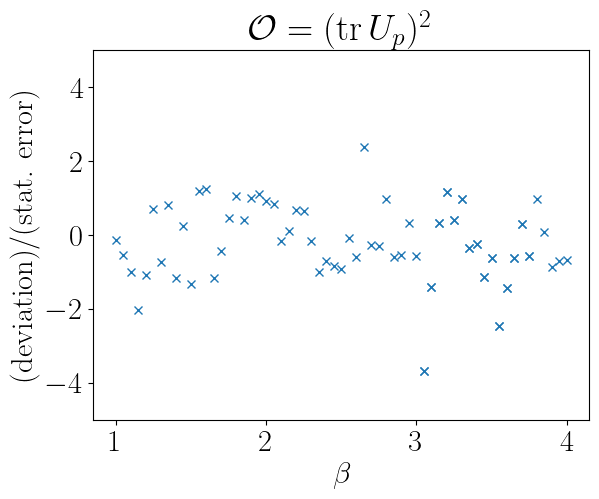

In [162]:
diff = res.T[2]-res.T[1]

plt.plot( res.T[0], diff / res.T[3], ls="none", marker="x")

plt.ylim(-5, 5)

plt.xlabel("$\\beta$")
plt.ylabel("(deviation)/(stat. error)")
plt.title("${\\cal O} = ({\\rm tr} \,U_p)^2 $")

plt.savefig("trUsqerr.pdf", bbox_inches="tight")

In [163]:
xx = np.arange( 1.0, 4.0, 0.01 )
yy = np.array( [(cF(lam20,beta)+cF(lam11,beta))/cF(lam00,beta) for beta in xx ] )

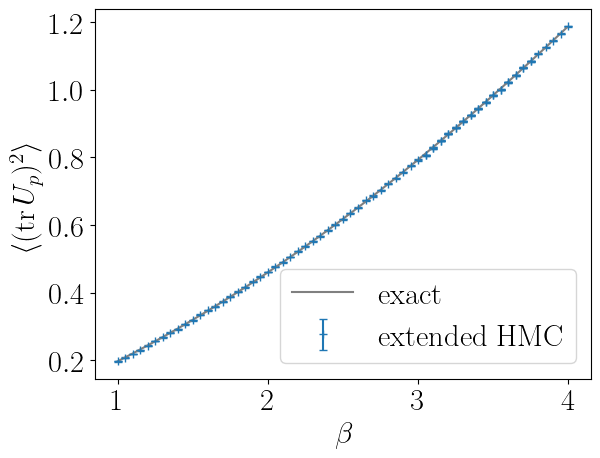

In [164]:
plt.errorbar( res.T[0], res.T[2], res.T[3], 
             ls='none', marker="+",
             capsize=3.0, label="extended HMC")

plt.plot( xx, yy, label="exact", c='gray' )

plt.xlabel("$\\beta$")
plt.ylabel("$\\langle ({\\rm tr} \,U_p)^2 \\rangle$")
plt.legend(loc="lower right")

plt.savefig("trUsq.pdf", bbox_inches="tight")

In [134]:
beta=3.0
betastr='{:.6f}'.format(beta)
trPhisq1 = np.loadtxt( "obs"+betastr+"_5.000000_1.000000_/trPhisq"+betastr+"_.dat" )
trPhisq2 = np.loadtxt( "obs"+betastr+"_5.000000_2.000000_/trPhisq"+betastr+"_.dat" )
trPhisq3 = np.loadtxt( "obs"+betastr+"_5.000000_3.000000_/trPhisq"+betastr+"_.dat" )

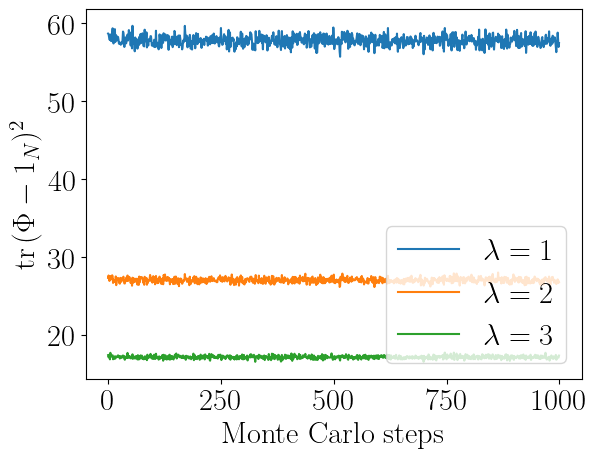

In [135]:
plt.plot( trPhisq1.T[1], label="$\\lambda=1$" )
plt.plot( trPhisq2.T[1], label="$\\lambda=2$" )
plt.plot( trPhisq3.T[1], label="$\\lambda=3$" )
plt.xlabel("Monte Carlo steps")
plt.ylabel("$ {{\\rm tr}\, (\\Phi - {1_N})^2 }$")

plt.legend(loc="lower right")
plt.savefig("trPhiM1.pdf", bbox_inches="tight")

plt.show()

In [136]:
"$\\mathbb{1}_N$"

'$\\mathbb{1}_N$'

In [137]:
retrU1 = np.loadtxt( "obs"+betastr+"_5.000000_1.000000_/retrU"+betastr+"_.dat" )
retrU2 = np.loadtxt( "obs"+betastr+"_5.000000_2.000000_/retrU"+betastr+"_.dat" )
retrU3 = np.loadtxt( "obs"+betastr+"_5.000000_3.000000_/retrU"+betastr+"_.dat" )

In [138]:
jk1 = Jackknife( N, binsize )
jk1.set( simple_mean, retrU1.T[1] )
jk1.do_it()

exact = cF( lam10, beta )/cF( lam00, beta )
print("ReTrU", format_print_w_exact( exact, jk1.mean(), jk1.err() ))

ReTrU 0.60866(95): 0.59032 sigma


In [139]:
jk1 = Jackknife( N, binsize )
jk1.set( simple_mean, retrU2.T[1] )
jk1.do_it()

exact = cF( lam10, beta )/cF( lam00, beta )
print("ReTrU", format_print_w_exact( exact, jk1.mean(), jk1.err() ))

ReTrU 0.6086(10): 0.6315 sigma


In [140]:
jk1 = Jackknife( N, binsize )
jk1.set( simple_mean, retrU3.T[1] )
jk1.do_it()

exact = cF( lam10, beta )/cF( lam00, beta )
print("ReTrU", format_print_w_exact( exact, jk1.mean(), jk1.err() ))

ReTrU 0.60963(80): -0.50711 sigma


In [141]:
retrU1 = np.loadtxt( "obs"+betastr+"_5.000000_1.000000_/retrUsq"+betastr+"_.dat" )
retrU2 = np.loadtxt( "obs"+betastr+"_5.000000_2.000000_/retrUsq"+betastr+"_.dat" )
retrU3 = np.loadtxt( "obs"+betastr+"_5.000000_3.000000_/retrUsq"+betastr+"_.dat" )

In [142]:
jk1 = Jackknife( N, binsize )
jk1.set( simple_mean, retrU1.T[1] )
jk1.do_it()

exact = (cF(lam20,beta)+cF(lam11,beta))/cF( lam00, beta )
print("ReTrU", format_print_w_exact( exact, jk1.mean(), jk1.err() ))

ReTrU 0.7926(16): 0.5822 sigma


In [143]:
jk1 = Jackknife( N, binsize )
jk1.set( simple_mean, retrU2.T[1] )
jk1.do_it()

exact = (cF(lam20,beta)+cF(lam11,beta))/cF( lam00, beta )
print("ReTrU", format_print_w_exact( exact, jk1.mean(), jk1.err() ))

ReTrU 0.7920(19): 0.8101 sigma


In [144]:
jk1 = Jackknife( N, binsize )
jk1.set( simple_mean, retrU3.T[1] )
jk1.do_it()

exact = (cF(lam20,beta)+cF(lam11,beta))/cF( lam00, beta )
print("ReTrU", format_print_w_exact( exact, jk1.mean(), jk1.err() ))

ReTrU 0.7951(15): -1.0652 sigma


In [145]:
res_=[]
for beta in np.arange(1.0, 3.05, 0.05):
    betastr='{:.6f}'.format(beta)
    retrU = np.loadtxt( "obs"+betastr+"_5.000000_1.000000_/trPhisq"+betastr+"_.dat" )

    jk1 = Jackknife( N, binsize )
    jk1.set( simple_mean, retrU.T[1] )
    jk1.do_it()

    exact = (cF(lam20,beta)+cF(lam11,beta))/cF( lam00, beta )
    res_.append([beta, exact, jk1.mean(), jk1.err()])
    # print("ReTrU", format_print_w_exact( exact, jk1.mean(), jk1.err() ))

In [146]:
for beta in np.arange(3.05, 3.8, 0.05):
    betastr='{:.6f}'.format(beta)
    retrU = np.loadtxt( "obs"+betastr+"_5.000000_1.000000_/trPhisq"+betastr+"_.dat" )

    jk1 = Jackknife( N, binsize )
    jk1.set( simple_mean, retrU.T[1] )
    jk1.do_it()

    exact = (cF(lam20,beta)+cF(lam11,beta))/cF( lam00, beta )
    res_.append([beta, exact, jk1.mean(), jk1.err()])
    # print("ReTrU", format_print_w_exact( exact, jk1.mean(), jk1.err() ))

In [147]:
res

array([[1.00000000e+00, 1.96618450e-01, 1.96461579e-01, 1.00116883e-03],
       [1.05000000e+00, 2.08130705e-01, 2.07418943e-01, 1.40617853e-03],
       [1.10000000e+00, 2.19812480e-01, 2.18598662e-01, 1.23734542e-03],
       [1.15000000e+00, 2.31664799e-01, 2.29319535e-01, 1.17736158e-03],
       [1.20000000e+00, 2.43688630e-01, 2.42462209e-01, 1.17027858e-03],
       [1.25000000e+00, 2.55884889e-01, 2.56855354e-01, 1.30102404e-03],
       [1.30000000e+00, 2.68254431e-01, 2.67284149e-01, 1.32129024e-03],
       [1.35000000e+00, 2.80798055e-01, 2.81791578e-01, 1.12841577e-03],
       [1.40000000e+00, 2.93516498e-01, 2.92017856e-01, 1.14174209e-03],
       [1.45000000e+00, 3.06410435e-01, 3.06715400e-01, 1.11826623e-03],
       [1.50000000e+00, 3.19480478e-01, 3.17693107e-01, 1.18885750e-03],
       [1.55000000e+00, 3.32727170e-01, 3.34374657e-01, 1.54058359e-03],
       [1.60000000e+00, 3.46150993e-01, 3.47737740e-01, 1.15412906e-03],
       [1.65000000e+00, 3.59752355e-01, 3.58132664e

In [171]:
obs = np.loadtxt( "obs/retrUsq.dat" )

In [172]:
xx = np.arange( 1.0, 4.0, 0.01 )
yy = np.array( [(cF(lam20,beta)+cF(lam11,beta))/cF(lam00,beta) for beta in xx ] )

In [173]:
diff = obs.T[1]-np.array( [(cF(lam20,beta)+cF(lam11,beta))/cF( lam00, beta ) for beta in obs.T[0] ] )

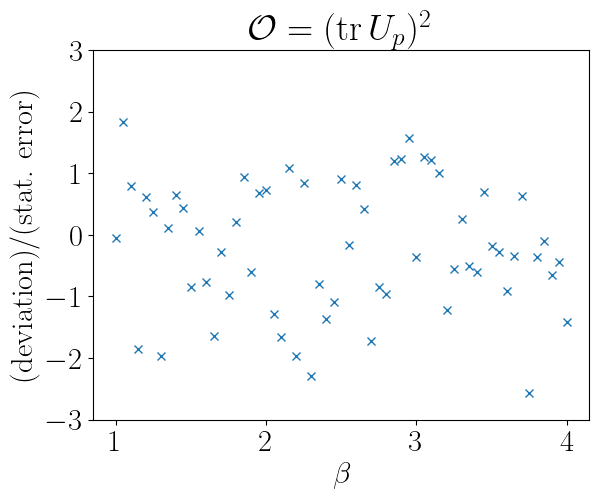

In [174]:
plt.plot( obs.T[0], diff / obs.T[2], ls="none", marker="x")

plt.ylim(-3, 3)

plt.xlabel("$\\beta$")
plt.ylabel("(deviation)/(stat. error)")
plt.title("${\\cal O} = ({\\rm tr} \,U_p)^2 $")
plt.savefig("trUsq_err.pdf", bbox_inches="tight")

In [175]:
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

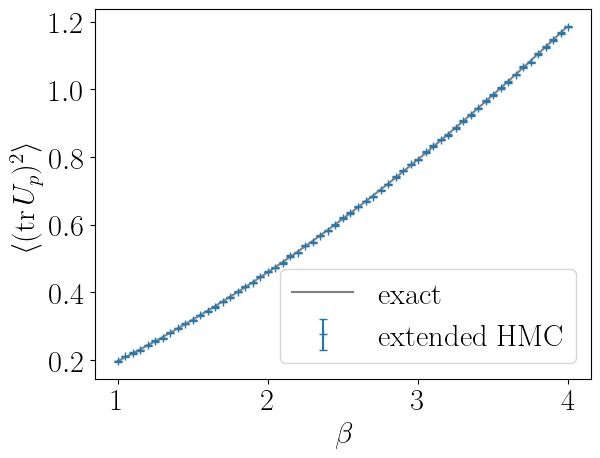

In [176]:
plt.errorbar( obs.T[0], obs.T[1], obs.T[2], 
             ls='none', marker="+",
             capsize=3.0, label="extended HMC")

plt.plot( xx, yy, label="exact", c='gray' )

plt.xlabel("$\\beta$")
plt.ylabel("$\\langle ({\\rm tr} \,U_p)^2 \\rangle$")
plt.legend(loc="lower right")
# plt.title("$SU(3)$, single plaquette, trivial $G$")
plt.savefig("trUsq.pdf", bbox_inches="tight")

In [177]:
obs.T[0]

array([1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ,
       1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05,
       2.1 , 2.15, 2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 ,
       2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15,
       3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 ,
       3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  ])

In [31]:
obs = np.loadtxt( "obs/retrUtrUdag.dat" )

FileNotFoundError: obs/retrUtrUdag.dat not found.

In [ ]:
xx = np.arange( 0.0, 10.0, 0.01 )
yy = np.array( [1.0+(cF(lam21,beta))/cF(lam00,beta) for beta in xx ] )
yy[0] = 1.0

In [28]:
diff = obs.T[1]-np.array( [cF( lam21, beta )/cF( lam00, beta ) for beta in obs.T[0] ] )

In [29]:
diff

array([0.1657363 , 0.17679175, 0.1834269 , 0.18734623, 0.19941091,
       0.20725472, 0.2116948 , 0.22296637, 0.23189554, 0.23958836,
       0.24553342, 0.25502571, 0.26151551, 0.26799525, 0.27831957,
       0.28511087, 0.29490005])

In [30]:
obs.T[2]

array([0.00147813, 0.00153161, 0.00159414, 0.00160379, 0.00154398,
       0.00176233, 0.00153368, 0.00166665, 0.00158154, 0.00158618,
       0.00163928, 0.0015924 , 0.00182906, 0.00174972, 0.00166484,
       0.00162597, 0.00167241])

Text(0.5, 1.0, '$SU(3)$, single plaquette, trivial $G$')

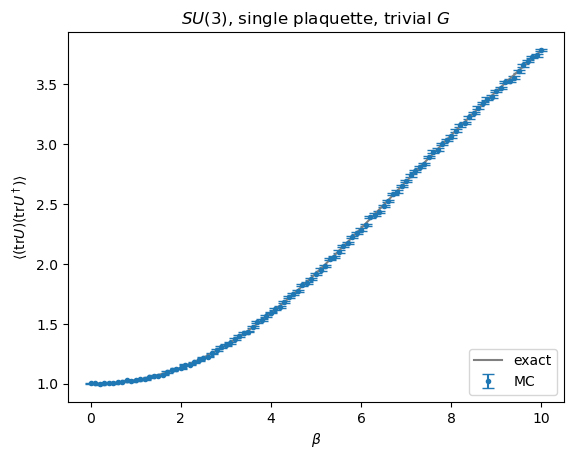

In [14]:
plt.errorbar( obs.T[0], obs.T[1], obs.T[2], 
             ls='none', marker='.',
             capsize=4.0, label="MC")

plt.plot( xx, yy, label="exact", c='gray' )

plt.xlabel("$\\beta$")
plt.ylabel("$\\langle ({\\rm tr} U)({\\rm tr} U^\\dagger) \\rangle$")
plt.legend(loc="lower right")
plt.title("$SU(3)$, single plaquette, trivial $G$")

In [15]:
obs = np.loadtxt( "obs/retrUcub.dat" )

In [16]:
xx = np.arange( 0.0, 10.0, 0.01 )
yy = np.array( [1.0+(cF(lam30,beta)+2.0*cF(lam21,beta))/cF(lam00,beta) for beta in xx ] )
yy[0] = 1.0

Text(0.5, 1.0, '$SU(3)$, single plaquette, trivial $G$')

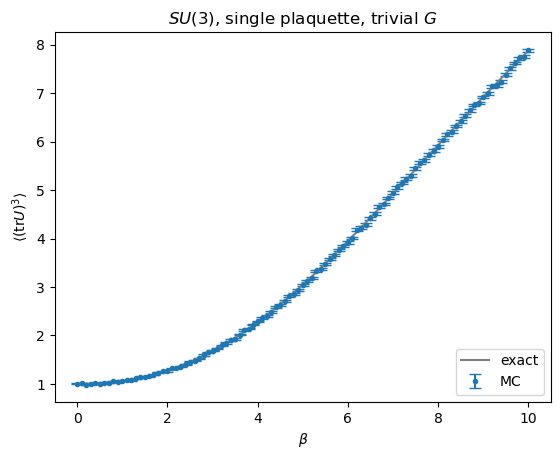

In [17]:
plt.errorbar( obs.T[0], obs.T[1], obs.T[2], 
             ls='none', marker='.',
             capsize=4.0, label="MC")

plt.plot( xx, yy, label="exact", c='gray' )

plt.xlabel("$\\beta$")
plt.ylabel("$\\langle ({\\rm tr} U)^3 \\rangle$")
plt.legend(loc="lower right")
plt.title("$SU(3)$, single plaquette, trivial $G$")

In [18]:
obs = np.loadtxt( "obs/retrUsqtrUdag.dat" )

In [19]:
xx = np.arange( 0.0, 10.0, 0.01 )
yy = np.array( [(cF(lam31,beta)+cF(lam22,beta)+2.0*cF(lam10,beta))/cF(lam00,beta) for beta in xx ] )
yy[0] = 0.0

Text(0.5, 1.0, '$SU(3)$, single plaquette, trivial $G$')

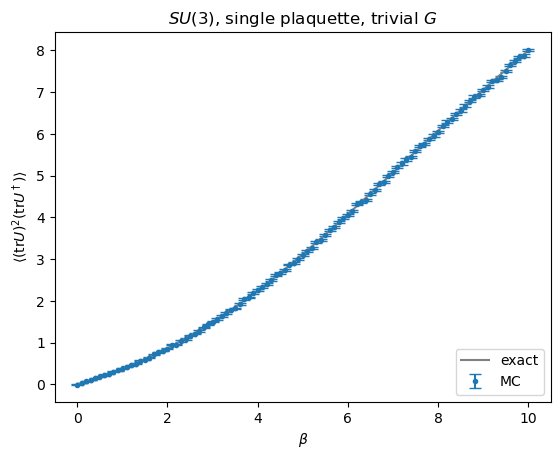

In [20]:
plt.errorbar( obs.T[0], obs.T[1], obs.T[2], 
             ls='none', marker='.',
             capsize=4.0, label="MC")

plt.plot( xx, yy, label="exact", c='gray' )

plt.xlabel("$\\beta$")
plt.ylabel("$\\langle ({\\rm tr} U)^2({\\rm tr} U^\\dagger) \\rangle$")
plt.legend(loc="lower right")
plt.title("$SU(3)$, single plaquette, trivial $G$")

In [23]:
obs.T[2]/obs.T[1]

array([-2.6075089 ,  0.27005388,  0.11852401,  0.08398413,  0.06226002,
        0.04821838,  0.04315647,  0.03782235,  0.03335729,  0.02991805,
        0.02773351,  0.025169  ,  0.02326765,  0.02255121,  0.02025816,
        0.01925655,  0.01831593,  0.01729765,  0.0167415 ,  0.01617259,
        0.01514688,  0.01407267,  0.0146054 ,  0.01340515,  0.01304924,
        0.01271148,  0.0124348 ,  0.01202286,  0.01163117,  0.01116379,
        0.01100095,  0.01078869,  0.01023374,  0.0099171 ,  0.00974788,
        0.00963806,  0.00961968,  0.00923614,  0.00891536,  0.00873276,
        0.00860609,  0.00861875,  0.00855575,  0.0081345 ,  0.00800937,
        0.00778831,  0.00754905,  0.00744742,  0.00753606,  0.00732869,
        0.00714332,  0.00706011,  0.00694416,  0.00681379,  0.00668029,
        0.00655189,  0.00647427,  0.00629297,  0.00621757,  0.00610338,
        0.00601331,  0.00600521,  0.00572956,  0.00566851,  0.0057097 ,
        0.00561816,  0.00543663,  0.00526611,  0.00526978,  0.00